In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

# Import preprocessing utilities
from EDA.clean_data import clean_data

# Import the LSTM module functions
from LSTM import (
    train_model_with_cv,
    evaluate_lstm_model,
    generate_evaluation_plots,
    analyze_feature_importance,
    plot_feature_importance
)

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'data', 'energy_cleaned.csv')

df = pd.read_csv(file_path)

df = clean_data(df)

df.head()


Dataset shape: (850, 67)
Number of companies: 118
Year range: 2015 to 2023


,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Country_New Zealand,Country_Norway,Country_Poland,Country_Portugal,Country_Spain,Country_Switzerland,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.66,55.296,42.616,41.717,...,False,False,False,False,True,False,False,False,False,False
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.05,55.497,48.354,36.578,...,False,False,False,False,True,False,False,False,False,False
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.11,57.248,50.317,44.891,...,False,False,False,False,True,False,False,False,False,False
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.64,62.609,52.280,59.039,...,False,False,False,False,True,False,False,False,False,False
5,ACS Actividades de Construccion y Servicios SA,ACS,2019,2.79,1.31,4.21,3.87,64.390,57.626,59.039,...,False,False,False,False,True,False,False,False,False,False


In [4]:
# Define target columns
target_cols = [
    'BESG ESG Score',
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
    'ESG Disclosure Score',
    'Environmental Disclosure Score',
    'Social Disclosure Score',
    'Governance Disclosure Score'
]

In [ ]:
# Train model with cross-validation
final_model, criterion, train_loader, test_loader, test_dataset, feature_names, history, device, best_params = train_model_with_cv(
    df,
    target_cols,
    hidden_sizes= [64, 128],
    num_layers_options=[3, 5],
    sequence_lengths=[3, 5, 7],
    learning_rates=[0.001, 0.005],
    n_splits=2,                    # Number of cross-validation folds
    epochs=1000,                    # Maximum number of training epochs
    patience=100,                  # Early stopping patience
    batch_size=32                  # Batch size for training
)

Using device: cpu

Testing with hidden_size=64, num_layers=3, seq_length=3, lr=0.001
  Fold 1/2
    Epoch 1/1000 | Train Loss: 1950.9529 | Val Loss: 1866.9549
    Epoch 2/1000 | Train Loss: 1981.6488 | Val Loss: 1866.6483
    Epoch 3/1000 | Train Loss: 2015.9441 | Val Loss: 1866.1939
    Epoch 4/1000 | Train Loss: 1962.3705 | Val Loss: 1865.2851
    Epoch 5/1000 | Train Loss: 1978.1123 | Val Loss: 1864.1659
    Epoch 6/1000 | Train Loss: 2006.0906 | Val Loss: 1862.0211
    Epoch 7/1000 | Train Loss: 1986.5735 | Val Loss: 1858.9291
    Epoch 8/1000 | Train Loss: 1986.0366 | Val Loss: 1854.6332
    Epoch 9/1000 | Train Loss: 1965.7708 | Val Loss: 1849.6476
    Epoch 10/1000 | Train Loss: 1965.9138 | Val Loss: 1844.6002
    Epoch 11/1000 | Train Loss: 1970.8596 | Val Loss: 1843.6641
    Epoch 12/1000 | Train Loss: 1972.8391 | Val Loss: 1842.6941
    Epoch 13/1000 | Train Loss: 1966.6295 | Val Loss: 1841.6139
    Epoch 14/1000 | Train Loss: 1981.7941 | Val Loss: 1841.1589
    Epoch 15/1000

In [6]:
# Display the best parameters found
print("\nBest parameters found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")


Best parameters found:
  hidden_size: 128
  num_layers: 3
  seq_length: 5
  learning_rate: 0.001


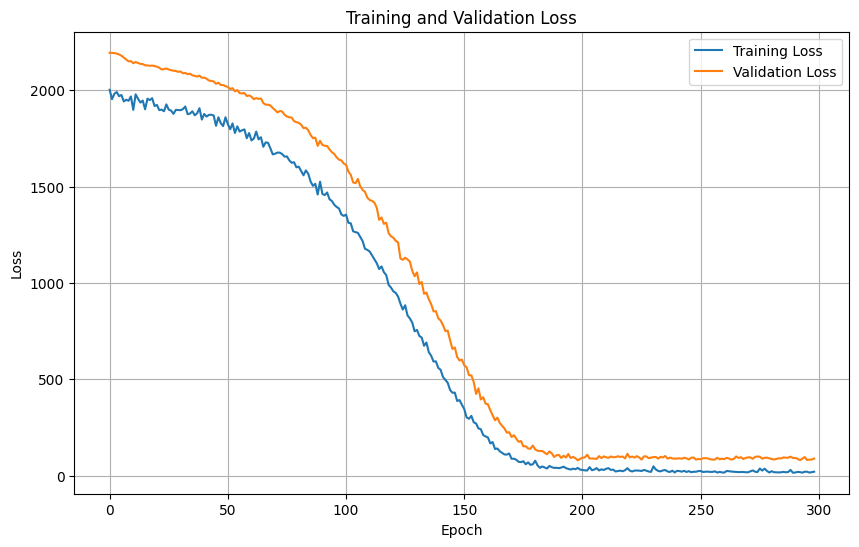

In [7]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluating model performance
eval_results = evaluate_lstm_model(
    final_model,
    test_loader,
    criterion,
    device,
    target_names=target_cols
)

In [9]:
# Print metrics
print(f"\nTest Loss: {eval_results['metrics']['test_loss']:.6f}")
print("\nMetrics by target:")
for name in target_cols:
    print(f"  {name}:")
    print(f"    MSE: {eval_results['metrics']['mse'][name]:.6f}")
    print(f"    RMSE: {eval_results['metrics']['rmse'][name]:.6f}")
    print(f"    MAE: {eval_results['metrics']['mae'][name]:.6f}")
    print(f"    R²: {eval_results['metrics']['r2'][name]:.6f}")

print("\nAverage metrics across all targets:")
print(f"  MSE: {eval_results['metrics']['mse']['average']:.6f}")
print(f"  RMSE: {eval_results['metrics']['rmse']['average']:.6f}")
print(f"  MAE: {eval_results['metrics']['mae']['average']:.6f}")
print(f"  R²: {eval_results['metrics']['r2']['average']:.6f}")


Test Loss: 79.168877

Metrics by target:
  BESG ESG Score:
    MSE: 1.379564
    RMSE: 1.174548
    MAE: 0.949909
    R²: -0.016620
  BESG Environmental Pillar Score:
    MSE: 2.456395
    RMSE: 1.567289
    MAE: 1.226522
    R²: 0.008732
  BESG Social Pillar Score:
    MSE: 2.419417
    RMSE: 1.555448
    MAE: 1.227187
    R²: -0.096463
  BESG Governance Pillar Score:
    MSE: 0.942497
    RMSE: 0.970823
    MAE: 0.758568
    R²: 0.489803
  ESG Disclosure Score:
    MSE: 84.131577
    RMSE: 9.172327
    MAE: 7.437915
    R²: 0.232171
  Environmental Disclosure Score:
    MSE: 252.855240
    RMSE: 15.901423
    MAE: 12.470004
    R²: 0.363617
  Social Disclosure Score:
    MSE: 188.609894
    RMSE: 13.733532
    MAE: 11.321964
    R²: 0.209206
  Governance Disclosure Score:
    MSE: 107.066422
    RMSE: 10.347291
    MAE: 8.333219
    R²: -0.195693

Average metrics across all targets:
  MSE: 79.982626
  RMSE: 6.802835
  MAE: 5.465661
  R²: 0.124344


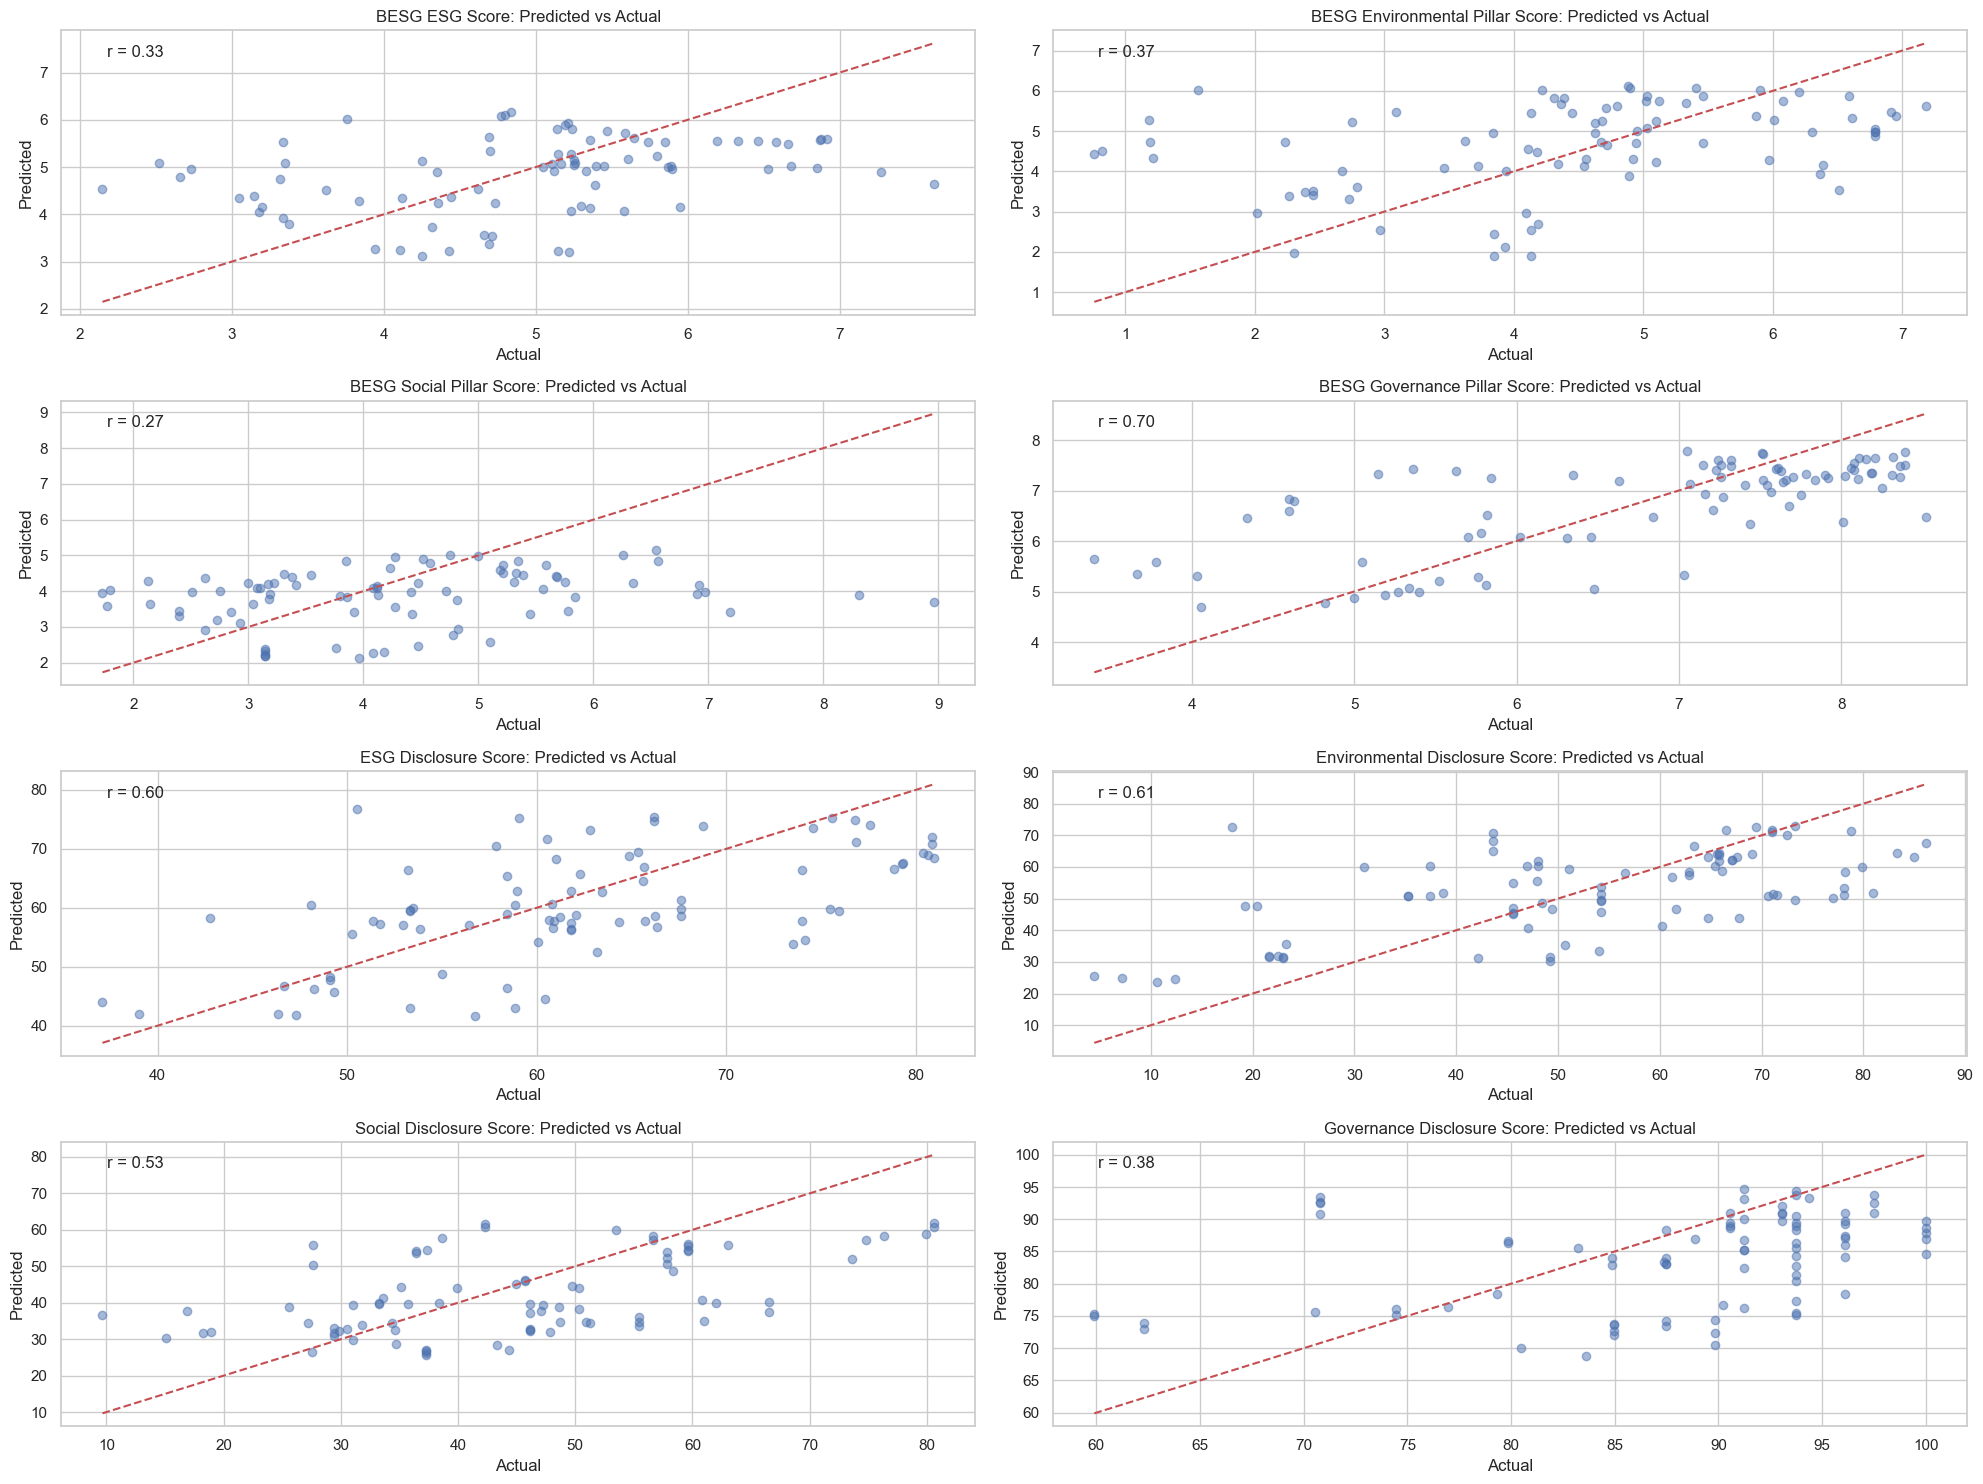

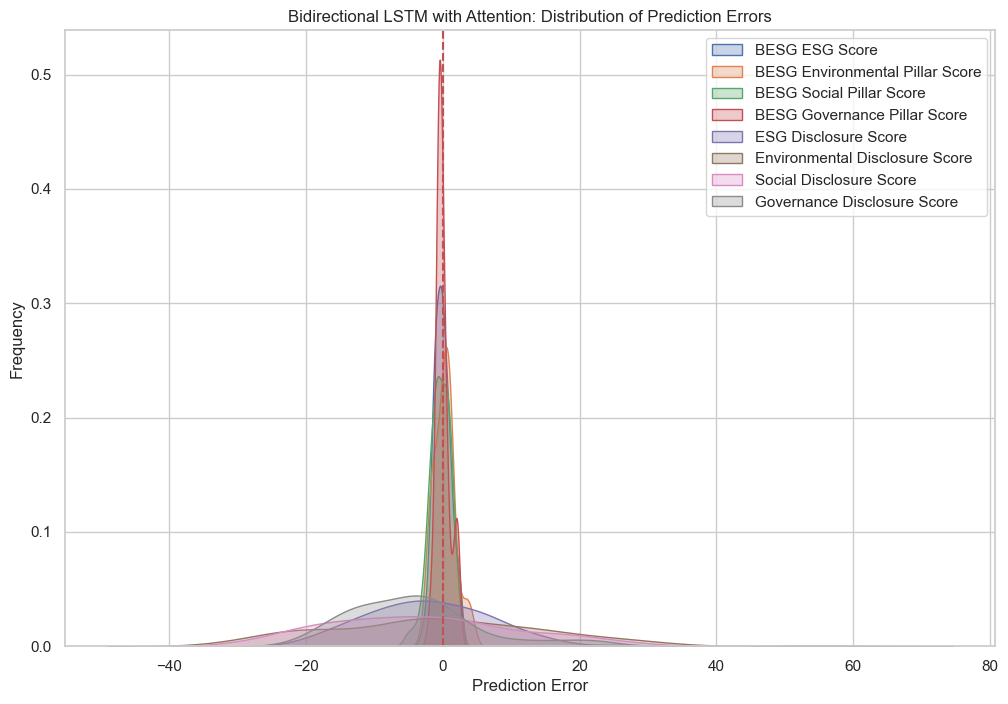

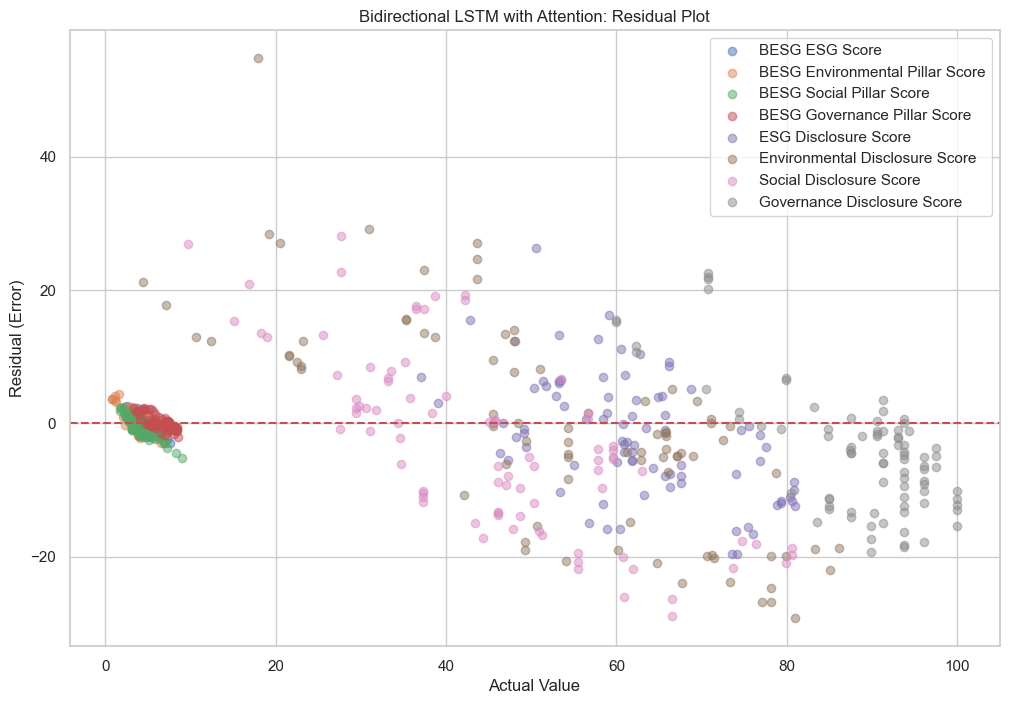


Model Performance Comparison:
                                         MSE      RMSE       MAE        R²
Bidirectional LSTM with Attention  79.982626  6.802835  5.465661  0.124344
TabTransformer                      0.052535  0.229205  0.154725  0.962071
Random Forest                       0.045979  0.214427  0.134578  0.966805


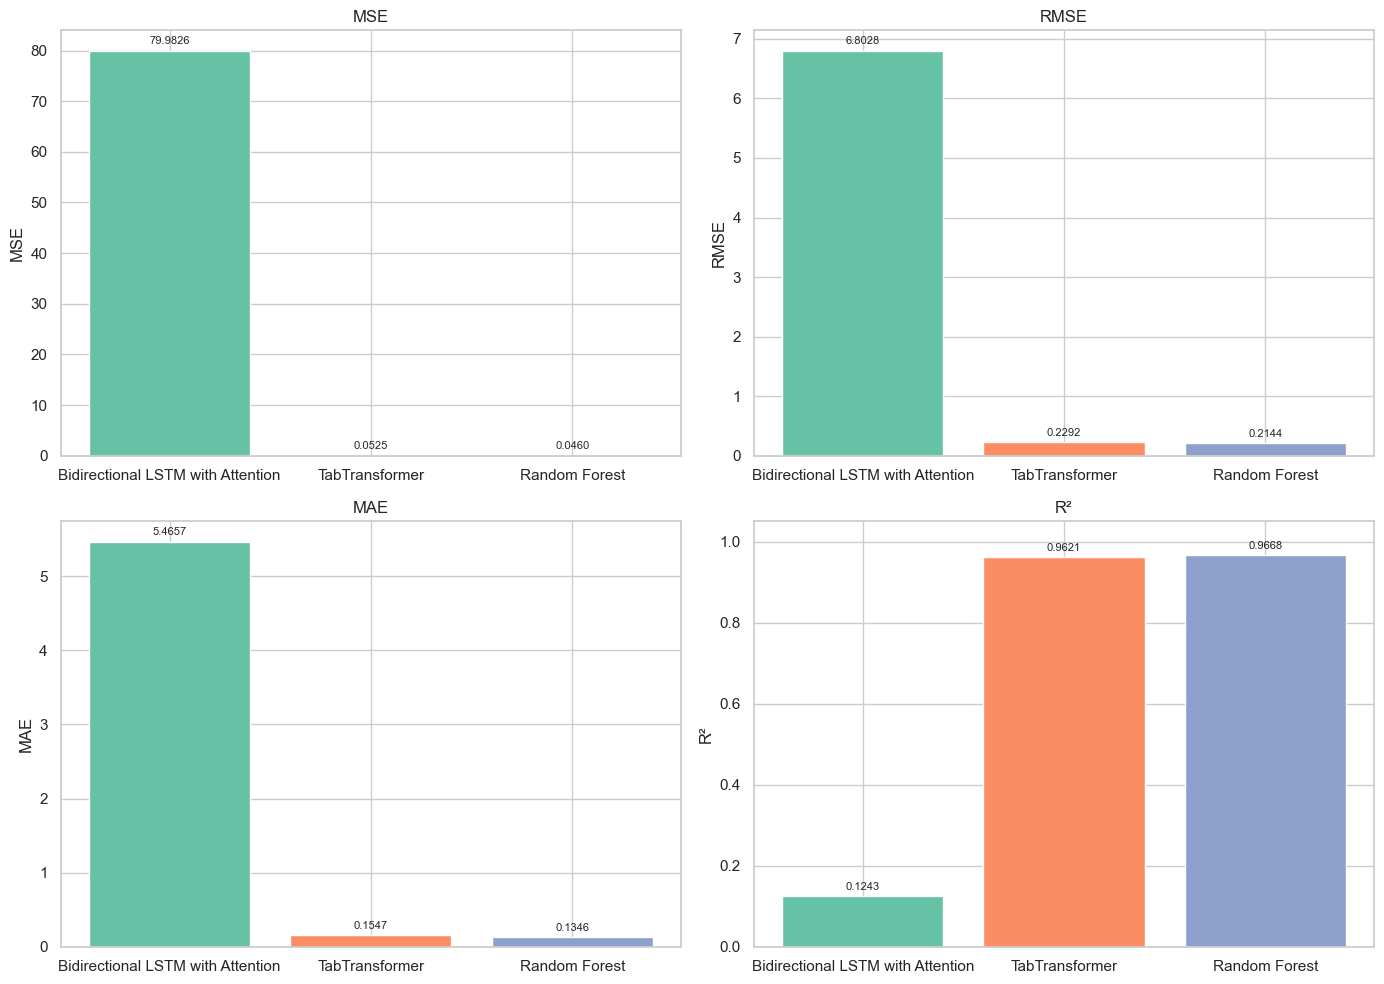

In [10]:
# Compare with other models
comparison_metrics = {
    'TabTransformer': {
        'MSE': 0.052535,
        'RMSE': 0.229205,
        'MAE': 0.154725,
        'R²': 0.962071
    },
    'Random Forest': {
        'MSE': 0.045979,
        'RMSE': 0.214427,
        'MAE': 0.134578,
        'R²': 0.966805
    }
}

# Generate evaluation plots
generate_evaluation_plots(
    eval_results,
    model_name="Bidirectional LSTM with Attention",
    compare_models=comparison_metrics
)

In [ ]:
# Analyze feature importance
importances = analyze_feature_importance(
    final_model,
    test_dataset,
    feature_names,
    device,
    n_samples=500
)

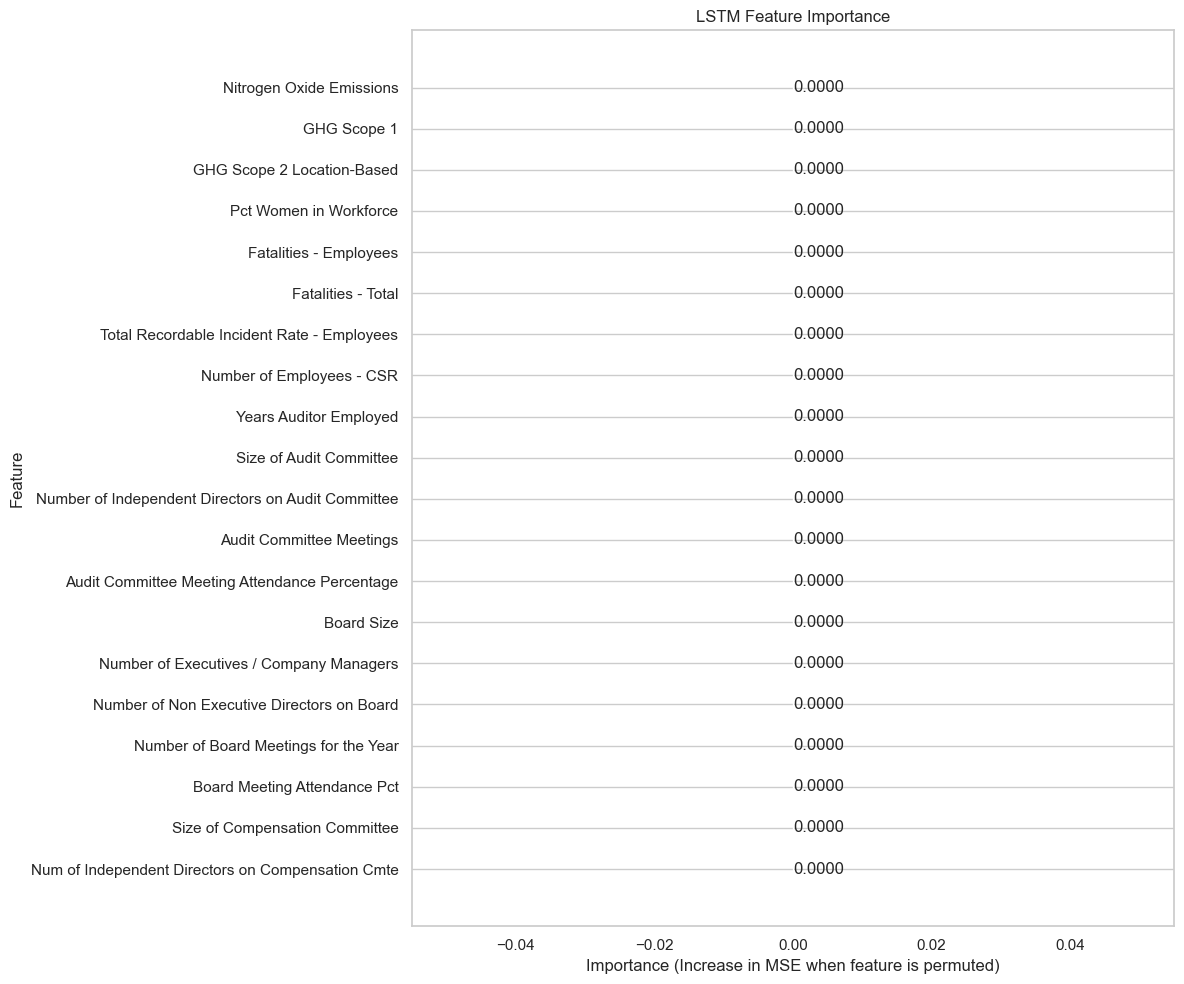

In [ ]:
# Plot feature importance
plot_feature_importance(
    importances,
    top_n=20,
    title="LSTM Feature Importance"
)

In [13]:
# Print top 10 most important features
print("\nTop 10 most important features:")
for i, (feature, importance) in enumerate(list(importances.items())[:10]):
    print(f"{i+1}. {feature}: {importance:.6f}")


Top 10 most important features:
1. Nitrogen Oxide Emissions: 0.000000
2. GHG Scope 1: 0.000000
3. GHG Scope 2 Location-Based: 0.000000
4. Pct Women in Workforce: 0.000000
5. Fatalities - Employees: 0.000000
6. Fatalities - Total: 0.000000
7. Total Recordable Incident Rate - Employees: 0.000000
8. Number of Employees - CSR: 0.000000
9. Years Auditor Employed: 0.000000
10. Size of Audit Committee: 0.000000


In [14]:
torch.save({
    'model_state_dict': final_model.state_dict(),
    'best_params': best_params,
    'feature_names': feature_names,
    'target_cols': target_cols
}, 'esg_lstm_model.pt')
